In [1]:
import dlib
from scipy.io import loadmat
from skimage import io
import argparse
import dlib
import glob
import cv2
from imutils import paths

In [2]:
filelist = glob.glob("/Users/Satish/Desktop/caltech-101/101_ObjectCategories/stop_sign/*")

In [3]:
filelist[0]

'/Users/Satish/Desktop/caltech-101/101_ObjectCategories/stop_sign/image_0001.jpg'

In [4]:
options = dlib.simple_object_detector_training_options()

In [5]:
images =[]
boxes =[]

for imagepath in filelist:
    imageID = imagepath.rsplit("/")[-1].rsplit("_")[1].replace(".jpg","")
    p = "/Users/Satish/Desktop/caltech-101/Annotations/stop_sign/annotation_{}.mat".format(imageID)
    annotations = loadmat(p)["box_coord"]
    bb = [dlib.rectangle(left=int(x), top=int(y), right=int(w), bottom=int(h)) for (y ,h , x, w) in annotations]
    boxes.append(bb)
    images.append(io.imread(imagepath))
    

In [6]:
print (len(images))
print (len(boxes))

64
64


In [7]:
print (images[0])
print (boxes[0])

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ..., 
 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
[rectangle(2,3,298,294)]


In [8]:
# train the object detector 
detector = dlib.train_simple_object_detector(images, boxes, options)

In [9]:
# dump the classifier as file
detector.save("/Users/Satish/Desktop/caltech-101/model.svm")

In [10]:
# load the detector 
detector = dlib.simple_object_detector("/Users/Satish/Desktop/caltech-101/model.svm")

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
# load the test image 
image = io.imread(imagepath)
boxes = detector(image)
print (boxes)

In [13]:
for b in boxes:
    (x, y, w, h) = (b.left(), b.top(), b.right(), b.bottom())
    cv2.rectangle(image, (x,y), (w,h), (0, 255 , 0), 2)
    print (x,y,w,h)

52 12 231 192


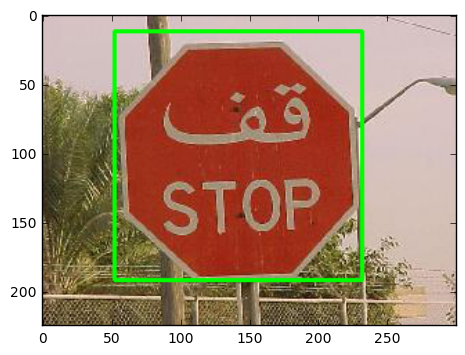

In [14]:
plt.imshow(image)
plt.show()

In [15]:
import json

In [16]:
with open('cars.json') as data_file:    
    data = json.load(data_file)
    
print (data)

{'image_distractions': '/Users/Satish/Desktop/caltech-101/SceneClass13', 'num_distraction_images': 500, 'cells_per_block': [2, 2], 'normalize': True, 'use_flip': True, 'overlap_thresh': 0.3, 'percent_gt_images': 0.5, 'features_path': '/Users/Satish/Desktop/caltech-101/car_features.hdf5', 'image_dataset': '/Users/Satish/Desktop/caltech-101/101_ObjectCategories/car_side', 'pyramid_scale': 1.5, 'window_step': 4, 'image_annotations': '/Users/Satish/Desktop/caltech-101/Annotations/car_side', 'window_dim': [96, 32], 'offset': 5, 'pixels_per_cell': [4, 4], 'C': 0.01, 'classifier_path': 'model.cpickle', 'num_distraction_per_image': 10, 'orientations': 9, 'min_probability': 0.7}


In [17]:
from sklearn.feature_extraction.image import extract_patches_2d
from pyimagesearch.object_detection import helpers
from pyimagesearch.descriptors.hog import HOG 
from pyimagesearch.utils import dataset
from pyimagesearch.utils.conf import * 
from imutils import paths 
from scipy import io 
from scipy.io import loadmat
import numpy as np 
from tqdm import tqdm 
import argparse
import random 
import cv2 
import glob

In [18]:
conf = Conf("cars.json")

In [19]:
conf

In [20]:
hog = HOG(orientations=conf["orientations"], pixelsPerCell = tuple(conf["pixels_per_cell"]),\
          cellsPerBlock= tuple(conf["cells_per_block"]), normalize=conf["normalize"])

In [21]:
hog

In [22]:
data = []
labels = []

In [23]:
# grad the set of ground truth images and select a percentage of them for training
trnPaths = glob.glob(conf["image_dataset"]+"/*")
print (len(trnPaths))
trnPaths = random.sample(trnPaths, int(len(trnPaths)* conf["percent_gt_images"]))
print (len(trnPaths))
print ("describing training ROI")

123
61
describing training ROI


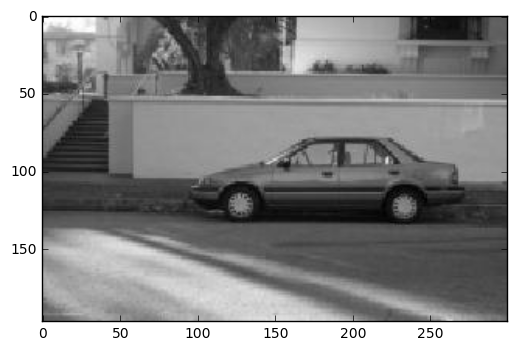

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.imshow(cv2.imread(trnPaths[23]))

In [25]:
# loop over the training paths
for (i, trnPath) in tqdm(enumerate(trnPaths)):
    image = cv2.imread(trnPath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    imageID = trnPath.rsplit("/")[-1].rsplit("_")[1].replace(".jpg","")
    p = conf["image_annotations"]+"/annotation_{}.mat".format(imageID)
    bb = loadmat(p)["box_coord"][0]
    roi = helpers.crop_ct101_bb(image, bb, padding=conf["offset"], dstSize=tuple(conf["window_dim"]))
    rois = (roi, cv2.flip(roi, 1)) if conf["use_flip"] else (roi,)

    for roi in rois:
        features = hog.describe(roi)
        data.append(features)
        labels.append(1)

In [26]:
print (len(data))
print (len(labels))

122
122


In [27]:
data[0].shape

(5796,)

In [28]:
# grad the set of ground truth images and select a percentage of them for training
dstPaths = glob.glob(conf["image_distractions"]+"/*")

In [29]:
dstPaths = [glob.glob(dstPaths[i]+"/*") for i in range(len(dstPaths))]

In [30]:
import itertools
merged = list(itertools.chain(*dstPaths))

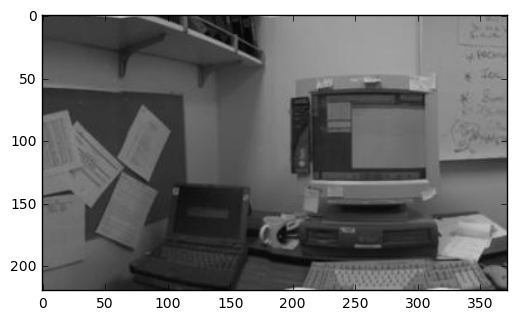

In [31]:
dstPaths = merged
plt.imshow(cv2.imread(random.choice(dstPaths)))

In [32]:
for i in tqdm(range(conf["num_distraction_images"])):
    image = cv2.imread(random.choice(dstPaths))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    patches = extract_patches_2d(image, tuple(conf["window_dim"]), max_patches=conf["num_distraction_per_image"])
    
    for patch in patches:
        features = hog.describe(patch)
        data.append(features)
        labels.append(-1)

In [33]:
len(data)

5122

In [34]:
labels

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -

In [35]:
from sklearn.svm import SVC 

In [36]:
model = SVC(kernel="linear", C = conf["C"], probability = True, random_state=42)
model.fit(data, labels)

SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

In [37]:
import _pickle as cPickle

In [38]:
with open(r"model.pickle", "wb") as output_file:
    cPickle.dump(model, output_file)

In [39]:
with open(r"model.pickle", "rb") as input_file:
    model = cPickle.load(input_file)

In [40]:
model

SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

In [41]:
from pyimagesearch.object_detection.objectdetector import ObjectDetector
from pyimagesearch.descriptors.hog import HOG
from pyimagesearch.utils.conf import Conf
import imutils
import argparse
import _pickle as cPickle
import cv2

In [42]:
hog = HOG(orientations=conf["orientations"], pixelsPerCell = tuple(conf["pixels_per_cell"]),
cellsPerBlock=tuple(conf["cells_per_block"]), normalize=conf["normalize"])
od = ObjectDetector(model, hog)

In [43]:
image = cv2.imread(trnPaths[0])
image = imutils.resize(image, width=min(260,image.shape[1]))

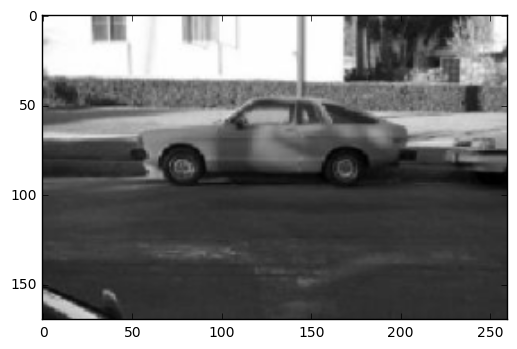

In [44]:
plt.imshow(image)

In [45]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [46]:
(boxes, prob) = od.detect(gray, conf["window_dim"], winStep=conf["window_step"],pyramidScale=conf["pyramid_scale"], minProb=conf["min_probability"])

In [47]:
for (startX, startY, endX, endY) in boxes:
    cv2.rectangle(image,(startX, startY),(endX,endY), (0,0,255), 2)

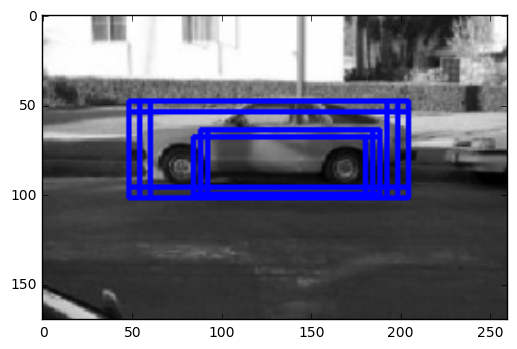

In [48]:
plt.imshow(image)

In [50]:
boxes

[(88, 64, 184, 96),
 (92, 64, 188, 96),
 (84, 68, 180, 100),
 (88, 68, 184, 100),
 (92, 68, 188, 100),
 (48, 48, 192, 96),
 (54, 48, 198, 96),
 (60, 48, 204, 96),
 (48, 54, 192, 102),
 (54, 54, 198, 102),
 (60, 54, 204, 102)]

In [57]:
np.asarray(boxes).dtype.kind

'i'

In [59]:
boxes = np.asarray(boxes).astype("float")

In [60]:
boxes[:,0]

array([ 88.,  92.,  84.,  88.,  92.,  48.,  54.,  60.,  48.,  54.,  60.])

In [63]:
x1= boxes[:,0]
y1= boxes[:,1]
x2= boxes[:,2]
y2= boxes[:,3]

In [64]:
area = (x2-x1+1)*(y2-y1+1)
print (area)

[ 3201.  3201.  3201.  3201.  3201.  7105.  7105.  7105.  7105.  7105.
  7105.]


In [66]:
prob

[0.74487429727912691,
 0.81586032971880462,
 0.80762483657488426,
 0.9107286113946641,
 0.89673118475444102,
 0.97247889898401196,
 0.98088259456423355,
 0.93597744835914565,
 0.89769863160123364,
 0.88830581997492586,
 0.80005024730206897]

In [72]:
idxs = np.argsort(prob)
print (idxs)

[ 0 10  2  1  9  4  8  3  7  5  6]


In [74]:
i = idxs[-1]
print (i)

6


In [73]:
print (x1)
print (x2)
print (y1)
print (y2)

[ 88.  92.  84.  88.  92.  48.  54.  60.  48.  54.  60.]
[ 184.  188.  180.  184.  188.  192.  198.  204.  192.  198.  204.]
[ 64.  64.  68.  68.  68.  48.  48.  48.  54.  54.  54.]
[  96.   96.  100.  100.  100.   96.   96.   96.  102.  102.  102.]


In [75]:
np.maximum(x1[6], x1[idxs[:6]])

array([ 88.,  60.,  84.,  92.,  54.,  92.])

In [76]:
x1[6]

54.0

In [77]:
x1[idxs[:6]]

array([ 88.,  60.,  84.,  92.,  54.,  92.])

In [78]:
idxs[:6]

array([ 0, 10,  2,  1,  9,  4])

In [80]:
area[idxs[:10]]

array([ 3201.,  7105.,  3201.,  3201.,  7105.,  3201.,  7105.,  3201.,
        7105.,  7105.])